In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import coint

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.svm import SVC
from sklearn.model_selection import KFold


from numpy.random import normal
import seaborn as sns

In [2]:
from AFML_module.log_uniform_rand import logUniform

In [3]:
def getTestData(n_features=40, n_informative=10, n_redundant=10, n_samples=10000):
    
    
    from sklearn.datasets import make_classification
    from pandas.tseries.offsets import BDay
    import datetime
    
    trnsX, cont = make_classification(n_samples=n_samples,
                                      n_features=n_features, 
                                      n_informative=n_informative,
                                      n_redundant=n_redundant,
                                      random_state=0,
                                      shuffle=False)
    
    df0 = pd.date_range(end=datetime.datetime.today(), periods=n_samples, freq=BDay())
    
    trnsX = pd.DataFrame(trnsX, index=df0)
    cont = pd.Series(cont, index=df0).to_frame('bin')
    
    df0 = ['I_'+str(i) for i in range(n_informative)] + ['R_'+str(i) for i in range(n_redundant)]
    df0 += ['N_'+str(i) for i in range(n_features-len(df0))]
     
    trnsX.columns=df0
    cont['w']=1./cont.shape[0]
    cont['t1']=pd.Series(cont.index, index=cont.index)
    
    return trnsX, cont

# Exercises

### 9.1

Using the function getTestData from Chapter 8, form a synthetic dataset of
10,000 observations with 10 features, where 5 are informative and 5 are noise.

(a) Use GridSearchCV on 10-fold CV to find the C, gamma optimal hyperparameters on a SVC with RBF kernel, where param_grid={'C':[1E2,1E-1,1,10,100],'gamma':[1E-2,1E-1,1,10,100]} and the scoring function is neg_log_loss.

(b) How many nodes are there in the grid?

(c) How many fits did it take to find the optimal solution?

(d) How long did it take to find this solution?

(e) How can you access the optimal result?

(f) What is the CV score of the optimal parameter combination?

In [4]:
# Generate test data. trnsX is a collection of features at each timestamp
# cont has a column called bin, which is the target value. It is 0 or 1.
trnsX, cont = getTestData(n_features=5, n_informative=5, n_redundant=0, n_samples=1_000)

In [5]:
trnsX.head(5)

,I_0,I_1,I_2,I_3,I_4
2021-11-02 21:31:46.025321,-0.046248,1.144745,-0.987279,3.333160,4.051760
2021-11-03 21:31:46.025321,-1.413096,1.182676,-0.708346,1.768376,-0.272121
2021-11-04 21:31:46.025321,-0.150822,1.693635,-2.436068,-1.472918,1.246785
2021-11-05 21:31:46.025321,-3.185603,0.738761,0.847584,2.593292,-0.771326
2021-11-08 21:31:46.025321,-1.078696,1.169550,-0.482905,3.814971,1.504417


In [6]:
cont.head(5)

,bin,w,t1
2021-11-02 21:31:46.025321,0,0.001,2021-11-02 21:31:46.025321
2021-11-03 21:31:46.025321,0,0.001,2021-11-03 21:31:46.025321
2021-11-04 21:31:46.025321,0,0.001,2021-11-04 21:31:46.025321
2021-11-05 21:31:46.025321,0,0.001,2021-11-05 21:31:46.025321
2021-11-08 21:31:46.025321,0,0.001,2021-11-08 21:31:46.025321


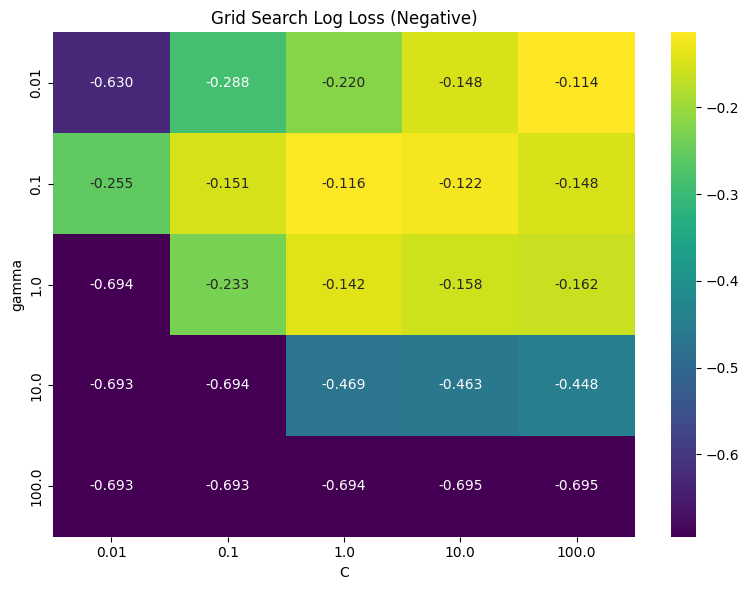

In [12]:
# Peform Grid Search Hyper Parameter Selection and Plot 
param_grid = {"C":     [1e-2, 1e-1, 1, 10, 100],
              "gamma": [1e-2, 1e-1, 1, 10, 100]}

clf = SVC(kernel="rbf", probability=True)
cv = KFold(n_splits=5, shuffle=False)

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="neg_log_loss")
gs.fit(trnsX, cont["bin"])

gs_results = pd.DataFrame(gs.cv_results_)

# Pivot table for heatmap
pivot_table = gs_results.pivot_table(
    index='param_gamma', 
    columns='param_C', 
    values='mean_test_score'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis")
plt.title("Grid Search Log Loss (Negative)")
plt.xlabel("C")
plt.ylabel("gamma")
plt.tight_layout()
plt.show()

In [8]:
print("Summary of Results")
gs_results[gs_results["rank_test_score"]==1]

Summary of Results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
20,0.01498,0.000739,0.001273,0.000049,100.0,0.01,"{'C': 100, 'gamma': 0.01}",-0.079379,-0.034309,-0.151216,-0.16313,-0.137414,-0.11309,0.048769,1


### 9.2

Using the same dataset from exercise 1,

(a) Use RandomizedSearchCV on 10-fold CV to find the C,
gamma optimal hyper-parameters on an SVC with RBF kernel,
where param_distributions={'C':logUniform(a=1E-2,b=
1E2),'gamma':logUniform(a=1E-2,b=1E2)},n_iter=25 and
neg_log_loss is the scoring function.

(b) How long did it take to find this solution?

(c) Is the optimal parameter combination similar to the one found in exercise 1?

(d) What is the CV score of the optimal parameter combination? How does it
compare to the CV score from exercise 1?

In [13]:
# using the same data set, seed and perform randomized grid search
param_distributions = {"C"    :logUniform(a=1e-2, b=1e2),
                       "gamma": logUniform(a=1e-2, b=1e2)}

clf = SVC(kernel="rbf", probability=True)
cv = KFold(n_splits=5, shuffle=False)

rs = RandomizedSearchCV(estimator=clf, param_distributions=param_distributions, n_iter=50, scoring="neg_log_loss")
rs.fit(trnsX, cont["bin"])

,estimator,SVC(probability=True)
,param_distributions,"{'C': <AFML_module....t 0x12c9af090>, 'gamma': <AFML_module....t 0x12c8b6f50>}"
,n_iter,50
,scoring,'neg_log_loss'
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


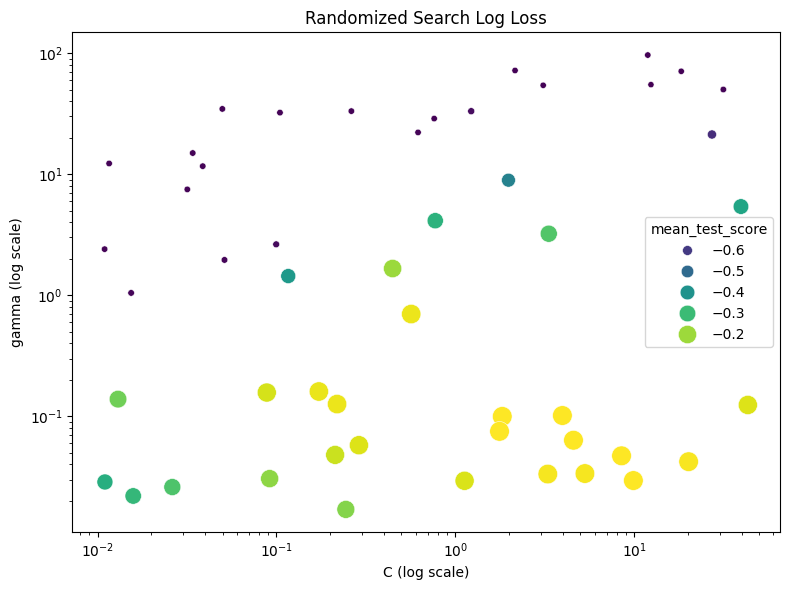

In [14]:
results = pd.DataFrame(rs.cv_results_)


plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=results,
    x="param_C", y="param_gamma",
    size="mean_test_score", hue="mean_test_score",
    palette="viridis", sizes=(20, 200), legend="brief"
)
plt.xscale("log")
plt.yscale("log")
plt.title("Randomized Search Log Loss")
plt.xlabel("C (log scale)")
plt.ylabel("gamma (log scale)")
plt.tight_layout()
plt.show()

In [15]:
results[results["rank_test_score"]==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
29,0.012042,0.00057,0.001291,0.000032,8.492386,0.047127,"{'C': 8.492386429995362, 'gamma': 0.0471274335...",-0.076741,-0.048637,-0.15264,-0.153399,-0.136442,-0.113572,0.042915,1


The mean test score and the optimal parameters are both quite close to the ones found in the prior exercise. It is also slightly faster to run the randomized grid search

### 9.3 - 9.4

9.3) From exercise 1,

(a) Compute the Sharpe ratio of the resulting in-sample forecasts, from point 1.a
(see Chapter 14 for a definition of Sharpe ratio).

(b) Repeat point 1.a, this time with accuracy as the scoring function. Compute
the in-sample forecasts derived from the hyper-tuned parameters.

(c) What scoring method leads to higher (in-sample) Sharpe ratio?

9.4 is the same exercise using randomized grid search.

We'll consider a very simple setup to make the point.  

The model predicts 0 or 1, by computing the probability of each outcome and choosing the option with > 50% probability.  If we predict 0, 
we'll bet 0. If we predict 1, we'll bet $p - 0.5$, where $p$ is the probability from our model.  If we are correct, we recieve the size of our bet in profit. If we are wrong, we lose the size of the bet from our current wealth. We'll allow our wealth to go arbitrarily positive or negative.

In [16]:
# use negative log loss in CV grid search to determine best hyperparameters
gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="neg_log_loss")
gs.fit(trnsX, cont["bin"])

gs.best_params_

{'C': 100, 'gamma': 0.01}

In [17]:
# use accuracy in CV grid search to determine best hyperparameters
gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="accuracy")
gs.fit(trnsX, cont["bin"])

gs.best_params_

{'C': 100, 'gamma': 0.01}

The chosen hyper parameters are identical, and so the sharp from the resulting models will be the same.  Intuitively, we'd expect that doing CV with cross entropy would select for hyperparameters that not only reward the model for making a correct prediction, but doing so with high confidence. Accuracy is not sensitive to this. Since we account for confidence in our bet sizing, we'd expect hyperparameters tuned with cross entropy to yield higher returns, and thus a higher sharpe ratio.

There is no difference with this particular toy dataset. The is because everything is classified with close to 100% conviction, so there is no difference between the accuracy and cross entropy metrics

Text(0.5, 1.0, 'Predicted Probabilities Reflect High Conviction')

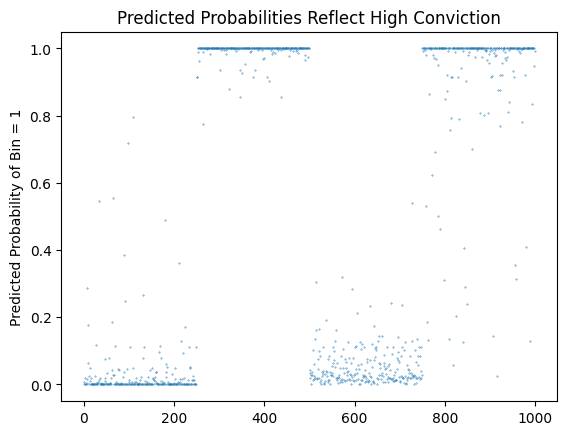

In [18]:
tuned_clf = SVC(kernel="rbf", probability=True, **gs.best_params_)
tuned_clf.fit(X=trnsX, y=cont['bin'])

predicted_probs = tuned_clf.predict_proba(trnsX)

plt.scatter(np.arange(predicted_probs.shape[0]), predicted_probs[:, 1], s=0.1)
plt.ylabel("Predicted Probability of Bin = 1")
plt.title("Observation")
plt.title("Predicted Probabilities Reflect High Conviction" )

### 9.6

Consider an investment strategy that sizes its bets equally, regardless of the forecast’s confidence. In this case, what is a more appropriate scoring function for
hyper-parameter tuning, accuracy or cross-entropy loss?

If we are sizing bets equally, then we should be using accuracy as our cross validation metric. When we evaluate hyperparameters, we want to use a metric which is similar to the metric that we will be using in deployment. If we size our bets equally, then our average returns will be given by, supposing we bet on every event, our return is given by

$$(\text{num correct} - \text{num incorrect}) / \text{num bets} = 2 * \text{accuracy} - 1$$
so we should be selecting hyperparameters based on the criterion of accuracy.